**In this we demonstrate how to utilize the concept of parallelization in Langgraph**

In [11]:
from langgraph.graph import StateGraph, START, END
from typing import Annotated, TypedDict
from IPython.display import display, Image



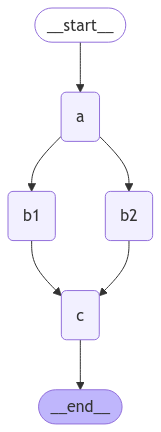

In [14]:
# Define graph schema (without any Reducer)
from token import STAR


class State(TypedDict):
    foo:int


# define the nodes
def a(state:State):
    print("---- Node A ----")
    return {"foo":state["foo"] + 1}

def b1(state:State):
    print("---- Node B1 ----")
    return {"foo":state["foo"] + 1}

def b2(state:State):
    print("---- Node B2 ----")
    return {"foo":state["foo"] + 1}

def c(state:State):
    print("---- Node C ----")
    return {"foo":state["foo"] + 1}

# Build the graph
builder = StateGraph(State)

builder.add_node("a",a)
builder.add_node("b1",b1)
builder.add_node("b2",b2)
builder.add_node("c",c)

builder.add_edge(START, "a")
builder.add_edge("a","b1")
builder.add_edge("a","b2")
builder.add_edge("b1","c")
builder.add_edge("b2","c")
builder.add_edge("c",END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [16]:
graph.invoke({"foo":1}) # This will give an error as we have not used any reducer. so, when making parallelization, we need to ensure that we use an appropriate reducer

---- Node A ----
---- Node B1 ----
---- Node B2 ----


InvalidUpdateError: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

**Demonstrating Reducer - We already saw this in Module 01**

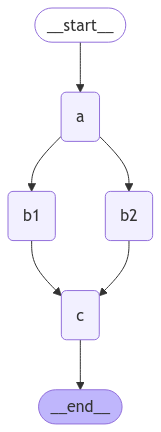

In [40]:
# define the updated schema
from operator import add
from langgraph.checkpoint.memory import MemorySaver


class State(TypedDict):
    foo : Annotated[list[int], add]

# define the nodes
def a(state:State):
    print("---- Node A ----")
    return {"foo": [state["foo"][-1] + 1]}

def b1(state:State):
    print("---- Node B1 ----")
    return {"foo": [state["foo"][-1] + 1]}

def b2(state:State):
    print("---- Node B2 ----")
    return {"foo": [state["foo"][-1] + 1]}

def c(state:State):
    print("---- Node C ----")
    return {"foo": [state["foo"][-1] + 1]}

# Build the graph
builder = StateGraph(State)

builder.add_node("a",a)
builder.add_node("b1",b1)
builder.add_node("b2",b2)
builder.add_node("c",c)

builder.add_edge(START, "a")
builder.add_edge("a","b1")
builder.add_edge("a","b2")
builder.add_edge("b1","c")
builder.add_edge("b2","c")
builder.add_edge("c",END)
checkpoint = MemorySaver()
graph = builder.compile(checkpointer=checkpoint)

display(Image(graph.get_graph().draw_mermaid_png()))

In [49]:
config = {"configurable":{"thread_id":"2"}}
graph.invoke({"foo":[0]}, config=config)

---- Node A ----
---- Node B1 ----
---- Node B2 ----
---- Node C ----


{'foo': [0, 1, 2, 2, 3]}

In [51]:
list(graph.get_state_history(config))

[StateSnapshot(values={'foo': [0, 1, 2, 2, 3]}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efdadd5-4ae4-6f76-8003-952ce8a9fe88'}}, metadata={'source': 'loop', 'writes': {'c': {'foo': [3]}}, 'thread_id': '2', 'step': 3, 'parents': {}}, created_at='2025-01-25T05:29:21.511188+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efdadd5-4ae4-6155-8002-0be8ac7de9ea'}}, tasks=()),
 StateSnapshot(values={'foo': [0, 1, 2, 2]}, next=('c',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efdadd5-4ae4-6155-8002-0be8ac7de9ea'}}, metadata={'source': 'loop', 'writes': {'b1': {'foo': [2]}, 'b2': {'foo': [2]}}, 'thread_id': '2', 'step': 2, 'parents': {}}, created_at='2025-01-25T05:29:21.510826+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efdadd5-4ae0-6bac-8001-6c0fe1b4ef64'}}, tasks=(PregelTask(id='49483359-6a09-fc29-87f1

**Build another Graph where a parallel node has more than one nodes**

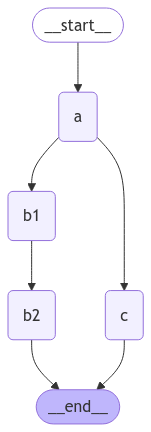

In [54]:
builder = StateGraph(State)

builder.add_node("a",a)
builder.add_node("b1",a)
builder.add_node("b2",a)
builder.add_node("c",a)

builder.add_edge(START, "a")
builder.add_edge("a","b1")
builder.add_edge("b1","b2")
builder.add_edge("a","c")
builder.add_edge("b2",END)
builder.add_edge("c",END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [56]:
graph.invoke({"foo":[1]})

---- Node A ----
---- Node A ----
---- Node A ----
---- Node A ----


{'foo': [1, 2, 3, 3, 4]}